In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Display the row's columns and data in dictionary format
print(session.query(Measurement).first().__dict__, '\n\n',\
      session.query(Station).first().__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x107293be0>, 'prcp': 0.08, 'station': 'USC00519397', 'tobs': 65.0, 'date': '2010-01-01', 'id': 1} 

 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x107293278>, 'elevation': 3.0, 'latitude': 21.2716, 'station': 'USC00519397', 'id': 1, 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US'}


# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


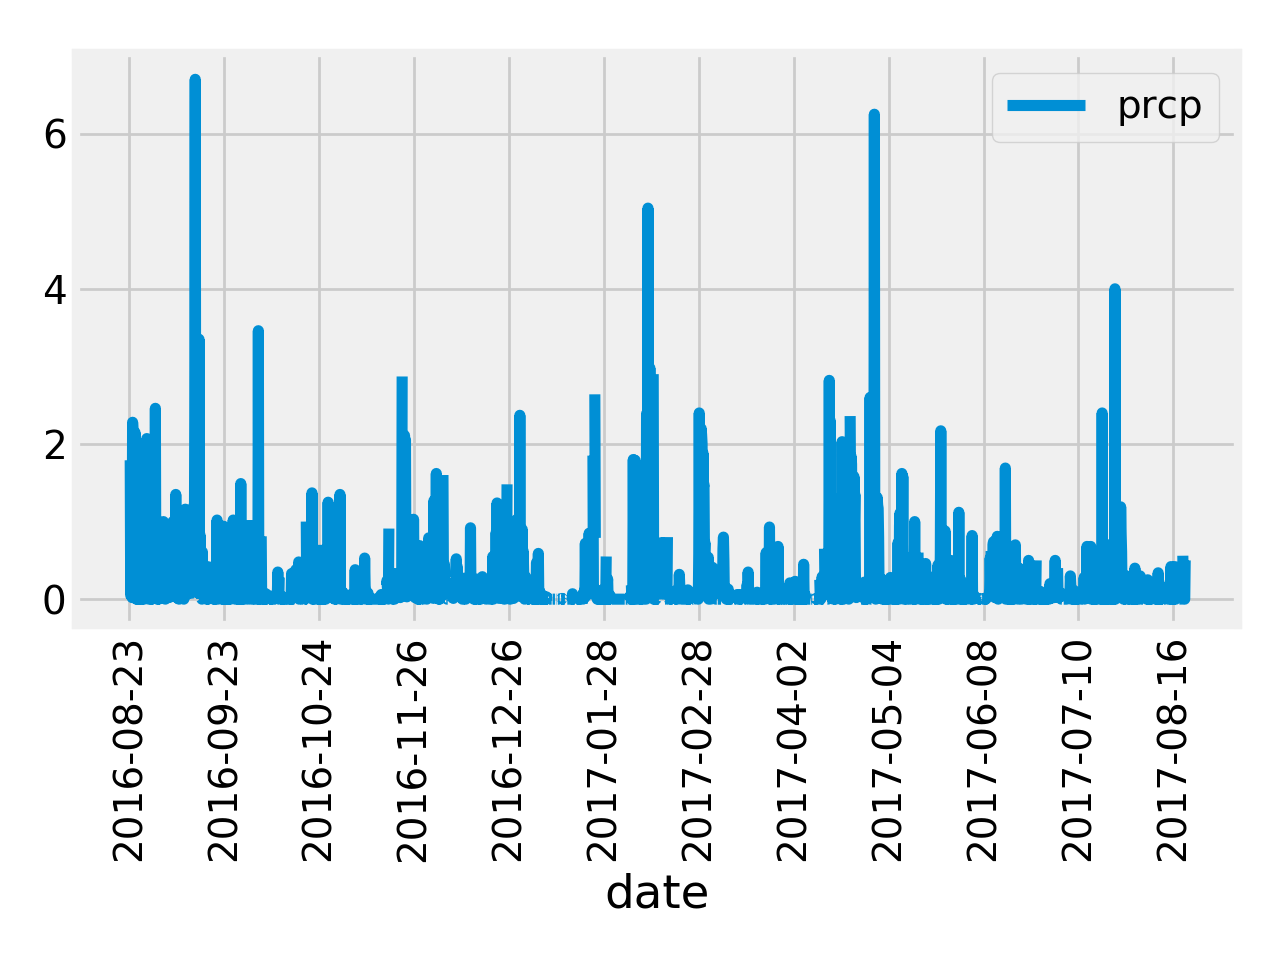

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Note: max_date = session.query(func.max(Measurement.date)).all()
# returns [('2017-08-23')], thus we'll set today's date to be 2017-08-23

# Calculate the date 1 year ago from today (today being 2017-08-23)
today = dt.date(2017, 8, 23)
year_ago = today - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_ago_measurements = session.query(Measurement.prcp, Measurement.date)\
                                     .filter(Measurement.date >= year_ago)\
                                     .filter(Measurement.date < today).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_ago_measurements_df = pd.DataFrame(year_ago_measurements, columns=['prcp', 'date'])
year_ago_measurements_df.set_index('date', inplace=True)

# Sort the dataframe by date
year_ago_measurements_df = year_ago_measurements_df.sort_index()

# Fill all NaN to 0
#year_ago_measurements_df = year_ago_measurements_df.fillna(0)

# Use Pandas Plotting with Matplotlib to plot the data
ax = year_ago_measurements_df.plot(use_index=True, y='prcp')

xtick_list = np.arange(0,year_ago_measurements_df.shape[0],200)
ax.set_xticks(xtick_list)
# Rotate the xticks for the dates
ax.set_xticklabels([year_ago_measurements_df.index[i] for i in xtick_list], rotation=90)


plt.tight_layout()
plt.show()


array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
       2200])

In [12]:
year_ago_measurements_df.index

Index(['2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23',
       '2016-08-23', '2016-08-23', '2016-08-24', '2016-08-24', '2016-08-24',
       ...
       '2017-08-20', '2017-08-20', '2017-08-20', '2017-08-21', '2017-08-21',
       '2017-08-21', '2017-08-21', '2017-08-22', '2017-08-22', '2017-08-22'],
      dtype='object', name='date', length=2226)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_ago_measurements_df.describe()

,prcp
count,2017.000000
mean,0.177367
std,0.461568
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
# alternate solution: session.query(Measurement.station).distinct().count()
session.query(func.distinct(Measurement.station)).count()

9

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                                     group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id = most_active_stations[0].station   # Take the first row for the most active
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
              .filter(Measurement.station == most_active_station_id).all()


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


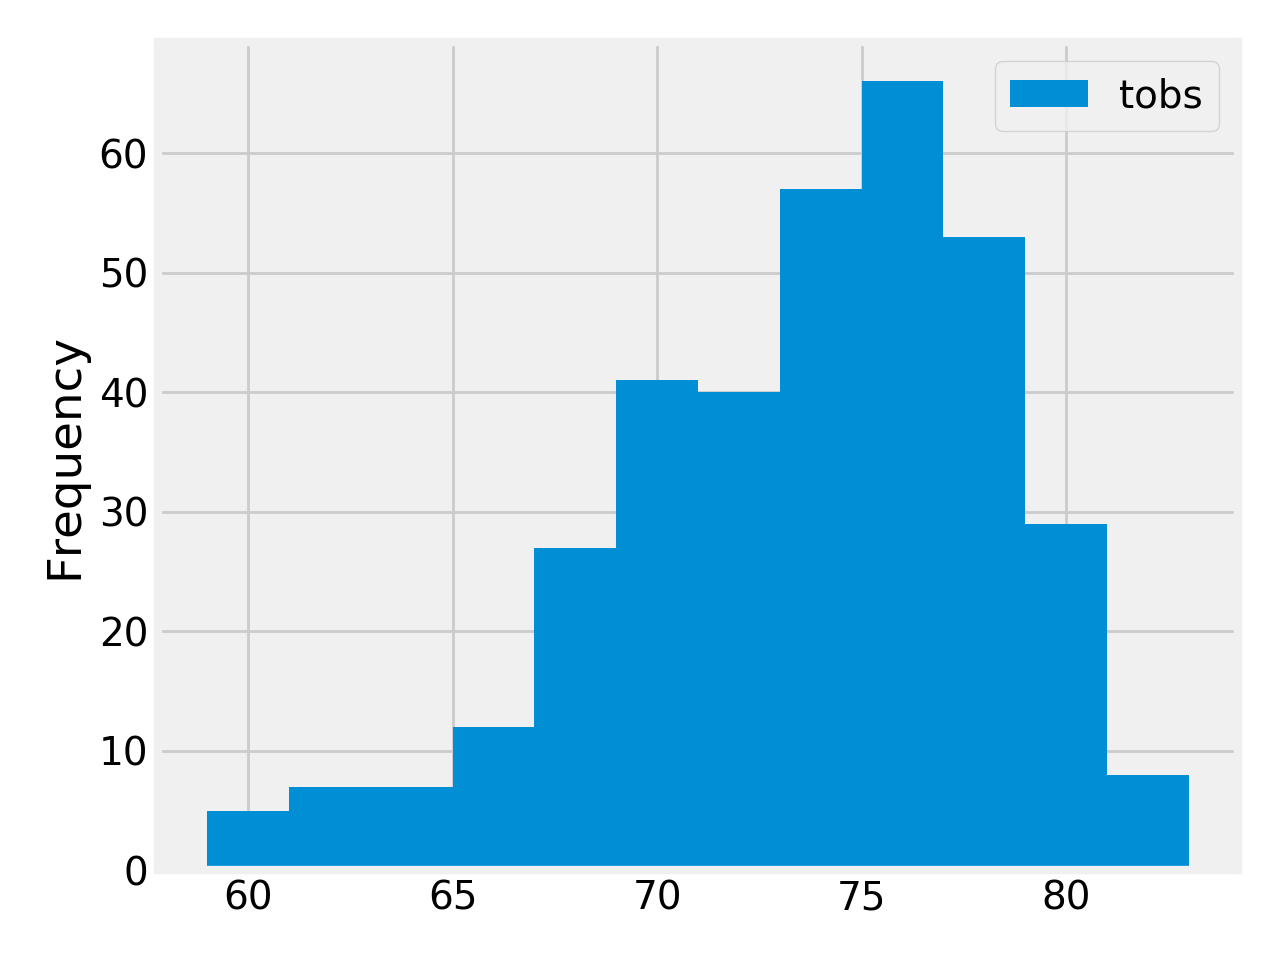

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_ago_MAS = session.query(Measurement.tobs)\
                            .filter(Measurement.station == most_active_station_id)\
                            .filter(Measurement.date >= year_ago)\
                            .filter(Measurement.date < today).all()

# Save the query results as a Pandas DataFrame and set the index to the tobs column
year_ago_MAS_df = pd.DataFrame(year_ago_MAS, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
year_ago_MAS_df.plot.hist(bins=12)

plt.tight_layout()
plt.show()

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Based off 10 days of vacation time : today = dt.date(2017, 8, 23)

start_date = today - dt.timedelta(days=365)
end_date = start_date + dt.timedelta(days=10)

tmin, tavg, tmax = calc_temps(start_date, end_date)[0]
print(tmin, tavg, tmax)

71.0 78.43055555555556 84.0


<IPython.core.display.Javascript object>


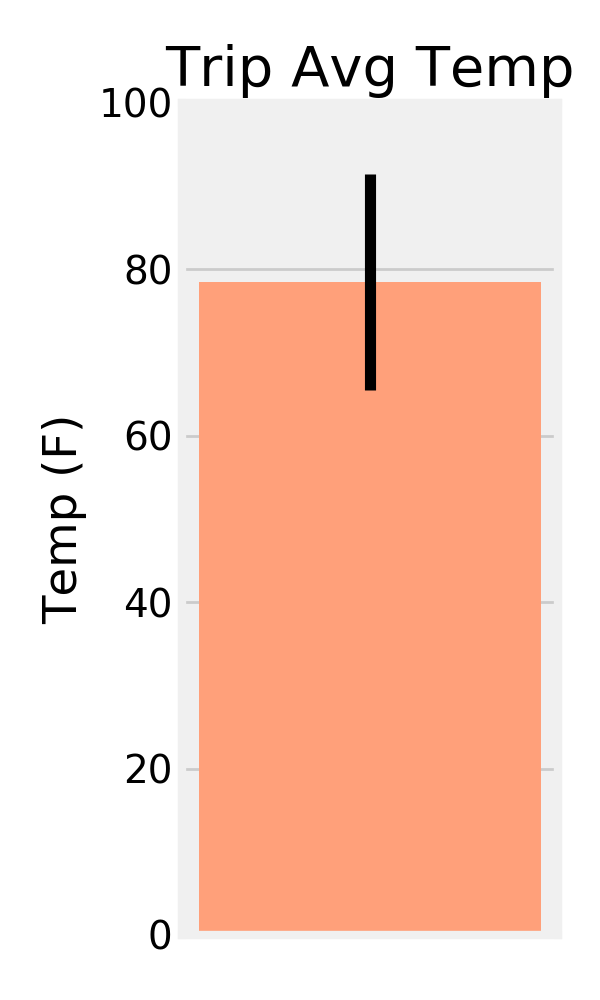

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#plt.rcdefaults()
fig = plt.figure(figsize=(3,5))

plt.subplot()
plt.bar(x=0, height=tavg, yerr=(tmax-tmin), color='lightsalmon')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.xticks([])

plt.tight_layout()
plt.show()

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# note: will continue to use variables: year_ago & today from above

sel = [Station.name, Station.latitude, Station.longitude, Station.elevation]
rainfall_data = session.query(*sel).filter(Measurement.station == Station.station )\
                       .filter(Measurement.date >= year_ago, Measurement.date < today)\
                       .order_by(Measurement.prcp.desc()).limit(10).all()

rainfall_data

[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip: based off 10 days starting with today @2017-8-23
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = today
vacation_days = 10
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
vac_dates_list = [(start_date + dt.timedelta(days=i)).strftime("%m-%d") for i in range(vacation_days)]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in vac_dates_list]
normals

[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
0,67.0,76.692308,87.0
1,70.0,75.961538,84.0
2,69.0,76.960784,82.0
3,71.0,76.568627,84.0
4,68.0,76.283019,84.0
5,67.0,76.734694,86.0
6,70.0,76.235294,85.0
7,68.0,76.416667,84.0
8,67.0,76.840000,85.0
9,69.0,77.000000,82.0


In [25]:
normals_df.index.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<IPython.core.display.Javascript object>


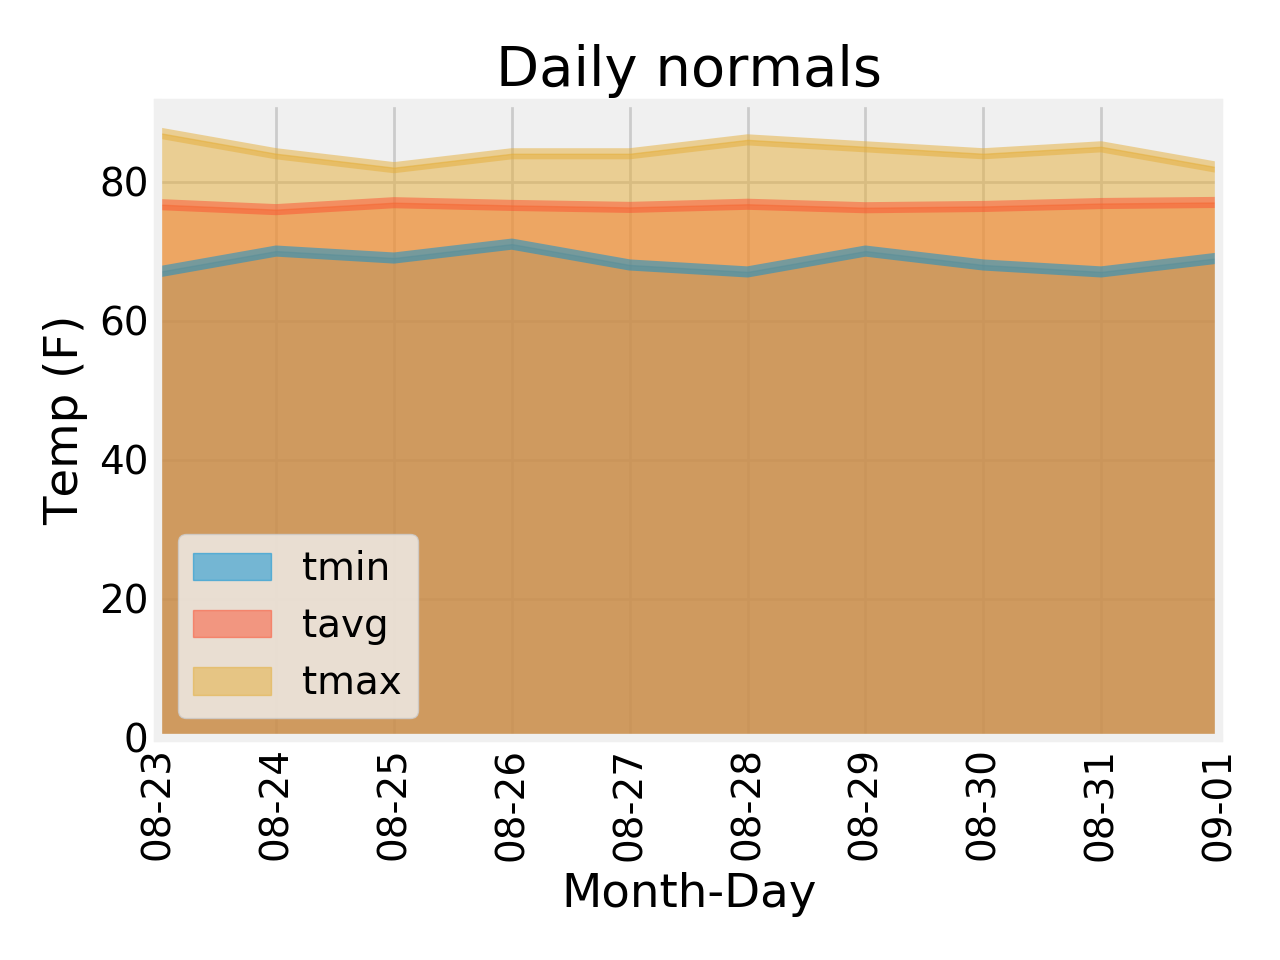

In [26]:
# Plot the daily normals as an area plot with `stacked=False`

ax = normals_df.plot.area(stacked=False)
ax.set_ylabel('Temp (F)')
ax.set_xlabel('Month-Day')
ax.set_xlim(0,9)
ax.set_xticklabels(vac_dates_list, rotation=90)
ax.set_title('Daily normals')

plt.tight_layout()
plt.show()